모듈 추가하기

In [2]:
import yaml
import graph
import debug
import numpy as np
from time import time
import image_data as data
import image_cropping as crop
import image_processing as process
from text_generation import make_random_text
# 모듈 자동 리로드하기
%load_ext autoreload
%autoreload 2


yaml파일 정보 가져오기


In [3]:
with open("./settings.yaml", encoding="utf-8") as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)


랜덤한 텍스트 생성하기


In [4]:
start_time = time()

text_generation_info = settings["textGeneration"]

seed = text_generation_info["seed"]
text_h_len = text_generation_info["textHLen"]
text_v_len = text_generation_info["textVLen"]
page_len = text_generation_info["pageLen"]
mode = text_generation_info["mode"]
text_len = text_h_len * text_v_len * page_len

random_text = make_random_text(seed, text_len, mode)

debug.show_elapsed_time(start_time)


elapsed time:0m 0.1s


이미지 파일 읽어오기 및 텍스트박스 추출


In [5]:
start_time = time()

image_info = settings["image"]
image_path = image_info["imagePath"]
image_perfix = image_info["imagePrefix"]
start_page = image_info["startPage"]
end_page = image_info["endPage"]

image_file_paths = []
for i in range(start_page, end_page + 1):
    image_file_path = image_path + image_perfix + str(i) + ".jpg"
    image_file_paths.append(image_file_path)

textbox_info = settings["textbox"]
denoise_info = settings["imageDenoise"]
textbox_images = []

for image_file_path in image_file_paths:
    textbox_image = crop.textbox_from_image(
        image_file_path, textbox_info, denoise_info)
    textbox_images.append(textbox_image)

print("Extracting textbox finished")
debug.show_elapsed_time(start_time)

# textbox_graph = textbox_images[0][:400, :400]
# graph.show_image(textbox_graph, (10, 10))


Extracting textbox finished
elapsed time:0m 9.5s


텍스트박스에서 줄 추출


In [6]:
start_time = time()

line_info = settings["line"]
line_footprint = np.ones(tuple(line_info["footprint"]))
line_thresh = line_info["lineThresh"]
line_images = []
line_avg_height = 0
page_cnt = 1
line_cnt = 1

for textbox_image in textbox_images:
    line_contours = data.get_line_contour_from_image(
        textbox_image, line_footprint, line_thresh)

    for line_contour in line_contours:
        line_image = crop.line_from_textbox(textbox_image, line_contour)
        line_avg_height += line_image.shape[0]
        line_images.append(line_image)
        # TODO debug 모듈에 오류감지함수 추가하기
        line_cnt += 1

    print(f"page {page_cnt} finished, line {line_cnt - 1} generated")
    page_cnt += 1
    line_cnt = 1

line_avg_height = int(line_avg_height / len(line_images))

print("Extracting line images finished")
debug.show_elapsed_time(start_time)


page 1 finished, line 173 generated
Extracting line images finished
elapsed time:0m 5.0s


줄 이미지 디버깅용 코드

In [33]:
line_info = settings["line"]
line_footprint = np.ones(tuple(line_info["footprint"]))

for i in range(len(line_images)):
    # if line_images[i].shape[1] < 2200 or line_images[i].shape[0] > 25:
    if i+1 == 3:
        print(i+1, line_images[i].shape)
        graph.show_image(line_images[i], (20, 20))
        d_img = process.make_dilated_image(
            line_images[i], line_footprint, thresh_correction=-0.3)
        graph.show_image(d_img, (20, 20))


3 (19, 2273)


In [7]:
line_images = line_images[:1]
line_images

[array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]])]

줄에서 글자의 간격에 대한 정보 추출

In [8]:
start_time = time()

char_info = settings["char"]
# 현재는 Ubuntu Mono R을 쓰고 있기에 footprint의 값으로 (1,2)를 해둠
# 조금 더 세로가 두꺼우면 get_gaps_data함수의 오류를 방지하는데 도움이 될 것 같아서임
# 만약 Ubuntu Mono B를 사용한다면 상황에 따라 dilation대신 binarization 사용
char_footprint = np.ones(tuple(char_info["footprint"]))
outlier_range = settings["gapOutlierRange"]
line_gaps_width, line_x_coords = data.get_gaps_data(
    line_images, char_footprint)

min_max_gaps, max_width = data.get_gaps_width(line_gaps_width, outlier_range)

print("Extracting gap data finished")
debug.show_elapsed_time(start_time)

Extracting gap data finished
elapsed time:0m 0.0s


줄에서 글자 추출

In [11]:
start_time = time()

char_image_len = line_avg_height * (max_width + 1)
char_data_array_len = char_image_len + max_width + line_avg_height + 1

chars_thresh = char_info["charsThresh"]
clean_thresh = char_info["cleanThresh"]

char_size_dict = {
    "char_w": max_width + 1,
    "char_h": line_avg_height,
    "data_len": char_data_array_len
}

line_cnt = 0
char_cnt = 0

char_data_array = np.zeros(
    (len(line_images) * text_h_len, char_data_array_len))

for line_idx, line_image in enumerate(line_images):
    gaps_width = line_gaps_width[line_idx]
    x_coords = line_x_coords[line_idx]
    min_max_gap = min_max_gaps[line_idx]

    line_start_time = time()

    for gap_idx, gap_width in enumerate(gaps_width):
        x_start, x_end = x_coords[gap_idx], x_coords[gap_idx + 1]

        if gap_width > min_max_gap[1]:  # gap_width > max_gap_width
            chars_image = line_image[:, x_start:x_end]

            seperated_chars = crop.char_from_chars(
                chars_image, chars_thresh, min_max_gap)
            # graph.show_image(char_image, (1, 1))

            for char_image in seperated_chars:
                try:
                    centered_char_image = process.move_char_image_to_center(
                        char_image, clean_thresh, char_size_dict)
                except Exception as e:
                    print(e)
                    print(line_cnt, char_cnt)
                    b_img = char_image > clean_thresh
                    graph.show_char(char_image, b_img)
                    continue
                # graph.show_image(char_image, (1, 1))
                char_data = data.add_stack_value_to_image(centered_char_image)
                char_data_array[char_cnt:] = char_data
                char_cnt += 1
        else:
            char_image = line_image[:, x_start:x_end]
            # char_image = process.move_char_image_to_center(
            #     char_image, skeleton_thresh, char_size_dict)
            # if char_cnt == 103:
            #     graph.show_image(char_image, (0.5, 0.5))
            try:
                centered_char_image = process.move_char_image_to_center(
                    char_image, clean_thresh, char_size_dict)
            except Exception as e:
                print(e)
                print(line_cnt, char_cnt)
                b_img = char_image > clean_thresh
                graph.show_char(char_image, b_img)
                continue
            # return 1
            char_data = data.add_stack_value_to_image(centered_char_image)
            char_data_array[char_cnt, :] = char_data
            char_cnt += 1
    debug.show_elapsed_time_per_line(
        start_time, line_start_time, line_cnt + 1, char_cnt, text_h_len)
    # TODO 글자들의 개수에 따라 이상을 감지하는 함수 추가하기
    # 정상적인 글자들의 데이터를 모은 뒤 어떤 글자들과도 일정 수준 일치하지 않으면 에러를 반환하는
    # 함수를 만들수도 있음
    line_cnt += 1


line 1 took: 0m0.1s expected:220 actual:220


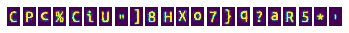

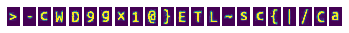

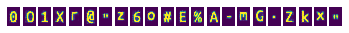

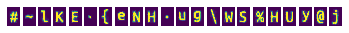

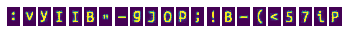

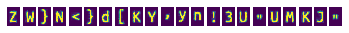

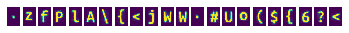

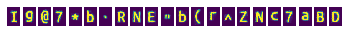

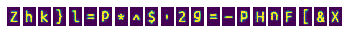

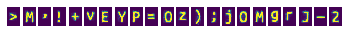

In [12]:
import matplotlib.pyplot as plt

for i in range(10):
    for j in range(22):
        img = np.reshape(char_data_array[22*i + j, :char_image_len], (char_size_dict["char_h"], char_size_dict["char_w"]))
        plt.subplot(1, 22, j+1)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

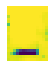

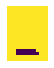

In [27]:
l_img = line_images[0]
# c_img = l_img[:, 13:25]
c_img = l_img[:, 1064:1078]
z_img = np.zeros_like(c_img)

c_info = settings["char"]["skeleton"]
clean = c_info["cleanCorrection"]
binary = c_info["binaryCorrection"]

c_bool = c_img > clean
c_cleaned_img = np.where(c_bool, c_img, z_img)
c_binary_img = process.make_binary_image(c_cleaned_img, binary)
graph.show_image(c_img, (1, 1))
graph.show_image(c_bool, (1, 1))
# graph.show_image(line_images[0][:, 1064:1078], (2, 2))


In [ ]:
npz_path = "./data/ascii-data"
# np.savez_compressed(npz_path, train_data=char_data_array, label_data=random_text)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_min = int(elapsed_time // 60)
elapsed_sec = round((elapsed_time % 60) * 10) / 10

print(
    f"image shape: {char_data_array.shape}\nelapsed time:{elapsed_min}m{elapsed_sec}s")
